**Before starting ...**

Checking we are using frugal-notebooks-env conda environment

In [1]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [2]:
!python --version

Python 3.9.21


Checking the pytorch version is > 1.12+ (compatibility with MPS)

In [3]:
import torch
print(torch.__version__)

2.5.1.post201


In [56]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Text classification exploration

## Let's explore the dataset

**Loading the dataset**

In [4]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [7]:
df = df[['quote', 'label']]
df.head()

,quote,label
0,"There is clear, compelling evidence that many ...",5_science_unreliable
1,"For most of the Holocene (last 10k years), sea...",1_not_happening
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant
4,It's going to be 42 here today and the hottest...,1_not_happening


**The label have 8 classes**

In [8]:
print('unique values:')
print('label\n', df['label'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']


**We might need to crop for max tokens / clariity of prompt**

In [13]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [14]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=400, title="Sentence Length Distribution")
fig.show(renderer='iframe')

In [15]:
threshold = np.percentile(df['text_length'], 90)
threshold

544.0

In [16]:
long_quotes = df[df['text_length'] > threshold]
print('Number of quotes above threshold: ', long_quotes.shape[0])

Number of quotes above threshold:  608


In [17]:
df['truncated_quote'] = df['quote'].str.slice(0, int(threshold))
df.head()

,quote,label,text_length,truncated_quote
0,"There is clear, compelling evidence that many ...",5_science_unreliable,277,"There is clear, compelling evidence that many ..."
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,279,"For most of the Holocene (last 10k years), sea..."
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,286,"China, which hosts U.N. climate talks next wee..."
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,146,And the fabricated documents (which Dr. Mann a...
4,It's going to be 42 here today and the hottest...,1_not_happening,123,It's going to be 42 here today and the hottest...


## LLM Baseline

In [18]:
# mistral, phi2, qwen

selected_model = "mistral"

**Model set-up**

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [20]:
MODEL_NAMES = {
    "mistral": "mistralai/Mistral-7B-Instruct-v0.1",
    "phi2": "microsoft/phi-2",
    "qwen": "Qwen/Qwen2.5-0.5B"
}
# "Qwen/Qwen2.5-7B"
# "Qwen/Qwen2.5-0.5B"
# "Qwen/Qwen2.5-1.5B"

#if torch.cuda.is_available():            # Nvidia GPU (T4)
#    DEVICE = "cuda"
#elif torch.backends.mps.is_available():  # Apple Silicon (M3)
#    DEVICE = "mps"
#else:
#    DEVICE = "cpu"

CLASS_LABELS = [
    "0_not_relevant",
    "1_not_happening",
    "2_not_human",
    "3_not_bad",
    "4_solutions_harmful_unnecessary",
    "5_science_unreliable",
    "6_proponents_biased",
    "7_fossil_fuels_needed"
]

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress multiprocessing warning


In [21]:
def load_model(model_name):

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
#        torch_dtype=(torch.float32 if DEVICE == "mps" else torch.float16),
        torch_dtype=torch.float16,
        device_map="auto"           # Auto-detects MPS (Apple Silicon)
    ).eval()                        # Disables dropout for consistent results

    return tokenizer, model

**Loading the model**

In [22]:
%%time
model_name = MODEL_NAMES[selected_model]
tokenizer, model = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 9.26 s, sys: 5.4 s, total: 14.7 s
Wall time: 19.6 s


In [23]:
!ls ~/.cache/huggingface/hub/

models--Qwen--Qwen2.5-0.5B
models--Qwen--Qwen2.5-7B
models--mistralai--Mistral-7B-Instruct-v0.1
version.txt


In [24]:
!du -sh ~/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1

 13G	/Users/a.villa.massone/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1


In [25]:
# to clear the cache
# from huggingface_hub.utils import hf_hub_download
# hf_hub_download.clear_cache()

**Prompt**

In [26]:
def create_prompt(text):
    pass
    return f"""Classify this climate statement into ONE category. Respond ONLY with the corresponding number (0-7).

Statement: {text}

Categories:
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to climate change are bad.
Claims against climate solutions.
Climate solutions are harmful or unnecessary

5 - Science is unreliable.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.

6 - Climate activists are bad.
Claims attacking climate scientists and activists
Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.

7 - Fossil fuels are a necessity.
Claims promoting fossil fuel necessity
We need fossil fuels for economic growth, prosperity, and to maintain our standard of living.

Category number:"""

In [27]:
def create_prompt(text):
    return f"""Classify this statement into ONE climate change category (0-7). Respond STRICTLY with only the corresponding number.

Statement: {text}

Categories:
0 - Not relevant to climate change:
No climate-related claims detected, or content unrelated to other categories.
"New sports stadium approved" | "Latest smartphone features"

1 - Climate change is not happening:
Explicitly denies global warming occurrence or its measurable impacts (e.g., rejects links to melting ice, extreme weather, sea level rise, or uses cold weather as counter-evidence).
"Global warming stopped in 2016" | "Record cold proves no climate change"

2 - Climate change is not caused by humans:
Attributes climate change primarily to natural causes, denying anthropogenic greenhouse gas influence.
"CO2 doesn't affect climate" | "Climate changes are natural cycles"

3 - Climate change is not bad:
Minimizes negative consequences or claims net benefits from climate change.
"Warmer winters will be better" | "CO2 helps plant growth"

4 - Climate solutions are harmful:
Opposes mitigation strategies as unnecessary, harmful, or counterproductive.
"Solar power ruins economies" | "EVs cause more pollution"

5 - Climate science is unreliable:
Challenges scientific consensus, methods, or motives in climate research.
"Climate models are guesses" | "Temperature data is fake"

6 - Climate actors are untrustworthy:
Attacks credibility/motives of scientists, activists, or institutions promoting climate action.
"Scientists are lying for grants" | "Activists want to control us"

7 - Fossil fuels are essential:
Asserts fossil fuels are critical for economic stability and quality of life.
"Oil is essential for progress" | "Coal keeps lights on"

Category number:"""

In [28]:
def create_prompt(text):
    pass
    return f"""Classify this climate statement into ONE category. Respond ONLY with the corresponding number (0-7).

Think step-by-step.

Categories:
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to climate change are bad.
Claims against climate solutions.
Climate solutions are harmful or unnecessary

5 - Science is unreliable.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.

6 - Climate activists are bad.
Claims attacking climate scientists and activists
Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.

7 - Fossil fuels are a necessity.
Claims promoting fossil fuel necessity
We need fossil fuels for economic growth, prosperity, and to maintain our standard of living.

Statement: {text}

Category number:"""

**Prediction function**

In [29]:
from codecarbon import EmissionsTracker

def classify_text(text, tokenizer, model):
    prompt = create_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    tracker = EmissionsTracker(log_level="error")
    tracker.start()
    
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=2,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    inference_emissions = tracker.stop()
    inference_time = tracker.final_emissions_data.duration
    inference_energy_conso = tracker.final_emissions_data.energy_consumed

    inf_efficiency_metrics_df = pd.DataFrame.from_dict([{
        "sample_inference_latency_sec": inference_time,
        "sample_inference_energy_conso_kWh": inference_energy_conso,
        "sample_inference_emissions_kgCO2eq": inference_emissions
    }])

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response, inf_efficiency_metrics_df

In [30]:
def parse_output(response):
    prediction = response.split("Category number:")[-1].strip()
    prediction = ''.join(filter(str.isdigit, prediction))
    
    if prediction.isdigit() and int(prediction) in range(8):
        return CLASS_LABELS[int(prediction)]
    return "error"

**Testing on a single sample**

In [31]:
df['truncated_quote'][0]

'There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example.'

In [32]:
sample_text = df['truncated_quote'][0]

single_sample_prediction, single_sample_metrics_df = classify_text(sample_text, tokenizer, model)

print(f"Model device: {model.device}")
print(f"next(model.parameters()).device: {next(model.parameters()).device}")

print(single_sample_prediction)
single_sample_prediction = parse_output(single_sample_prediction)

print(f"\nText: {sample_text}\n\nPrediction: {single_sample_prediction}\nTrue label: {df['label'][0]}\n")
single_sample_metrics_df.head()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model device: mps:0
next(model.parameters()).device: mps:0
Classify this climate statement into ONE category. Respond ONLY with the corresponding number (0-7).

Think step-by-step.

Categories:
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to cli

,sample_inference_latency_sec,sample_inference_energy_conso_kWh,sample_inference_emissions_kgCO2eq
0,5.516348,0.000079,0.000005


**Evaluation on larger sample**

In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [64]:
def batch_inference(model, tokenizer, X_test):
    predictions = []
    metrics_list = []
    errors = 0
    
    for quote in X_test:
        try:
            pred, metrics_df = classify_text(quote, tokenizer, model)
            pred = parse_output(pred)
            predictions.append(pred)
            metrics_list.append(metrics_df.iloc[0])
    
            if pred == "error":
                errors += 1
        except Exception as e:
            predictions.append("error")
            errors += 1
            print(f"Error processing: {text[:50]}... -> {str(e)}")

    if metrics_list:
        batch_metrics_df = pd.DataFrame(metrics_list, columns=[
            "sample_inference_latency_sec",
            "sample_inference_energy_conso_kWh",
            "sample_inference_emissions_kgCO2eq"
        ])
        inf_efficiency_metrics = {
            "total_inference_latency_sec": np.sum(batch_metrics_df['sample_inference_latency_sec']),
            "sample_inference_latency_sec": np.mean(batch_metrics_df['sample_inference_latency_sec']),
            "total_inference_energy_conso_kWh": np.sum(batch_metrics_df['sample_inference_energy_conso_kWh']),
            "sample_inference_energy_conso_kWh": np.mean(batch_metrics_df['sample_inference_energy_conso_kWh']),
            "total_inference_emissions_kgCO2eq": np.sum(batch_metrics_df['sample_inference_emissions_kgCO2eq'])
        }
    if errors:
        print(f"Total errors: {errors}")

    return predictions, inf_efficiency_metrics

In [65]:
random.seed(42)
torch.manual_seed(42)

N_SAMPLES = 50

df_test = df.sample(N_SAMPLES, random_state=42)
X_test = df_test['truncated_quote'].tolist()
y_test = df_test['label'].tolist()

len(X_test), len(y_test)

(50, 50)

In [66]:
y_pred, inf_efficiency_metrics_df = batch_inference(model, tokenizer, X_test)

**Efficiency Metrics**

In [67]:
inf_efficiency_metrics_df

{'total_inference_latency_sec': 205.64465999603271,
 'sample_inference_latency_sec': 4.112893199920654,
 'total_inference_energy_conso_kWh': 0.0029418137577176097,
 'sample_inference_energy_conso_kWh': 5.8836275154352194e-05,
 'total_inference_emissions_kgCO2eq': 0.00017072521961538378}

**Performance Metrics**

In [68]:
results = pd.DataFrame({
    'X_test': [t[:100]+'...' for t in X_test],
    'y_test': y_test,
    'y_pred': y_pred
})
results["correct"] = results["y_test"] == results["y_pred"]
results.head()

,X_test,y_test,y_pred,correct
0,Mann could be said to be the Jerry Sandusky of...,6_proponents_biased,6_proponents_biased,True
1,The reality is that the infra-red active gases...,2_not_human,0_not_relevant,False
2,“Late 20th century and early 21st century glob...,3_not_bad,1_not_happening,False
3,Our research has shown that the concentration ...,2_not_human,1_not_happening,False
4,I am speaking only as a layman who observes th...,1_not_happening,1_not_happening,True


In [69]:
accuracy = accuracy_score(results["y_test"], results["y_pred"])
category_names = sorted(results["y_test"].unique())

class_accuracy = pd.DataFrame(results).groupby("y_test")["correct"].mean().values
precision = precision_score(results["y_test"], results["y_pred"], average=None, labels=category_names)
recall = recall_score(results["y_test"], results["y_pred"], average=None, labels=category_names)
f1 = f1_score(results["y_test"], results["y_pred"], average=None, labels=category_names)

metrics_df = pd.DataFrame({
    "Category": category_names,
    "Accuracy": class_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})
metrics_df

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Category,Accuracy,Precision,Recall,F1 Score
0,0_not_relevant,0.666667,0.285714,0.666667,0.400000
1,1_not_happening,0.600000,0.230769,0.600000,0.333333
2,2_not_human,0.000000,0.000000,0.000000,0.000000
3,3_not_bad,0.375000,1.000000,0.375000,0.545455
4,4_solutions_harmful_unnecessary,0.000000,0.000000,0.000000,0.000000
5,5_science_unreliable,0.333333,0.600000,0.333333,0.428571
6,6_proponents_biased,0.142857,1.000000,0.142857,0.250000
7,7_fossil_fuels_needed,1.000000,0.285714,1.000000,0.444444


In [70]:
# Overall performance
correct = np.sum(results["correct"])
errors = np.sum(results["y_pred"] == 'error')
incorrect = len(results) - correct - errors

performance = pd.DataFrame({
    'Outcome': ['Correct', 'Incorrect', 'Error'],
    'Count': [
        correct,
        incorrect,
        errors
    ]
})
performance

,Outcome,Count
0,Correct,18
1,Incorrect,32
2,Error,0


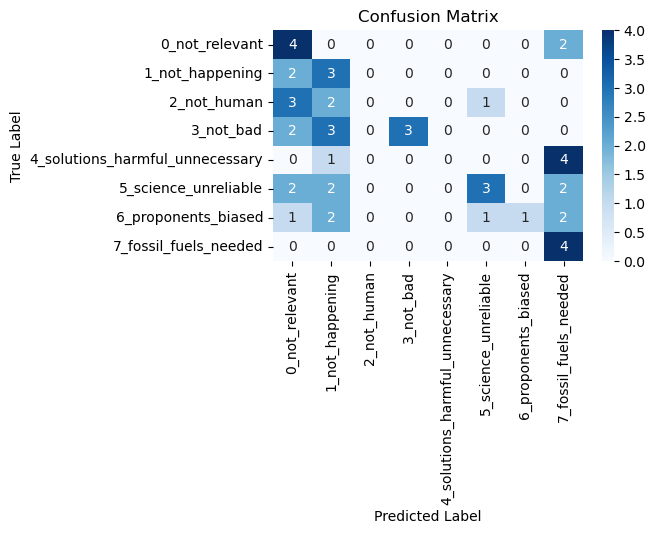

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

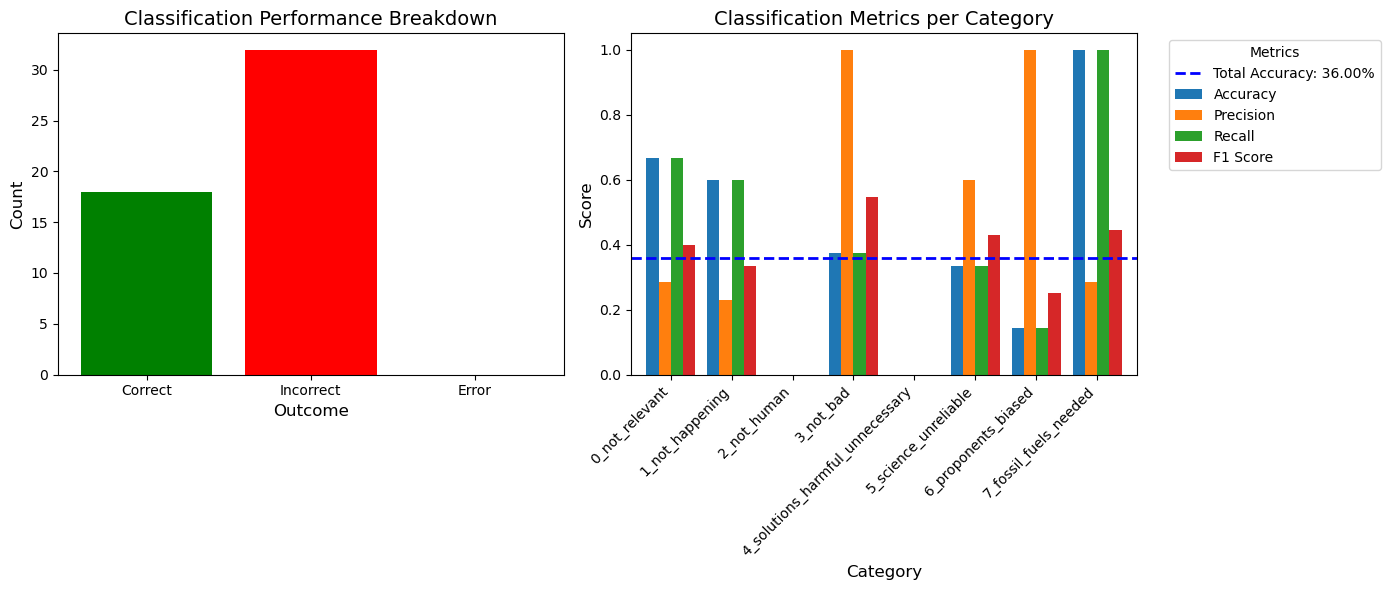

In [72]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Classification performance breakdown
axes[0].bar(performance['Outcome'], performance['Count'], color=['green', 'red', 'gray'])
axes[0].set_title("Classification Performance Breakdown", fontsize=14)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_xlabel("Outcome", fontsize=12)

# Second plot: Classification metrics per category
metrics_df.set_index("Category").plot(kind="bar", width=0.8, ax=axes[1])
axes[1].axhline(y=accuracy, color='blue', linestyle='dashed', linewidth=2, label=f'Total Accuracy: {accuracy:.2%}')
axes[1].set_title("Classification Metrics per Category", fontsize=14)
axes[1].set_ylabel("Score", fontsize=12)
axes[1].set_xlabel("Category", fontsize=12)
axes[1].set_xticklabels(metrics_df["Category"], rotation=45, ha="right")
axes[1].legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Category metrics
                          Category  Accuracy  Precision  Recall  F1 Score
0                   0_not_relevant      0.67       0.29    0.67      0.40
1                  1_not_happening      0.60       0.23    0.60      0.33
2                      2_not_human      0.00       0.00    0.00      0.00
3                        3_not_bad      0.38       1.00    0.38      0.55
4  4_solutions_harmful_unnecessary      0.00       0.00    0.00      0.00
5             5_science_unreliable      0.33       0.60    0.33      0.43
6              6_proponents_biased      0.14       1.00    0.14      0.25
7            7_fossil_fuels_needed      1.00       0.29    1.00      0.44



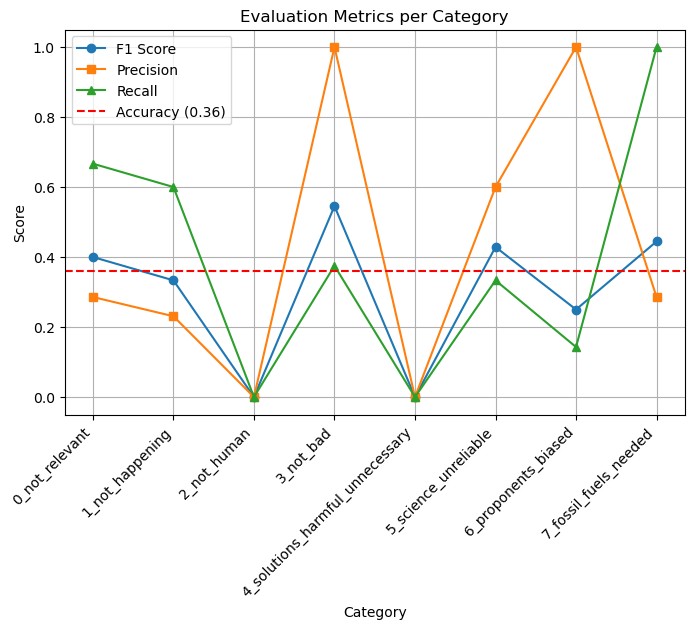

In [73]:
categories = metrics_df['Category']

plt.figure(figsize=(8, 5))

plt.plot(categories, metrics_df['F1 Score'], marker='o', label='F1 Score')
plt.plot(categories, metrics_df['Precision'], marker='s', label='Precision')
plt.plot(categories, metrics_df['Recall'], marker='^', label='Recall')

plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy ({accuracy:.2f})')

plt.xlabel("Category")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Category")
plt.xticks(categories, categories, rotation=45, ha="right")  # Align category names properly
plt.legend()
plt.grid(True)

print("Category metrics")
print(metrics_df.round(2))
print()
plt.show()
print()

**Let's save the results**

In [48]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-01-28_12:01:23'

In [49]:
filename = (
    "metrics/"
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{int(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
    ".json"
)
filename

'metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_36_dt_20250128_120123.json'

In [50]:
note = "Baseline SLM, prompt engineering - quote cropping, no fine-tune"

In [54]:
# ajouter category metrics

os.makedirs("metrics", exist_ok=True)

data = {
    "model_name": model_name,
    "timestamp": timestamp,
    "note": note,

    "test_accuracy": accuracy,

    "total_inference_latency_sec": inf_efficiency_metrics_df['metrics'].loc['total_inference_latency_sec'],
    "total_inference_energy_conso_kWh": inf_efficiency_metrics_df['metrics'].loc['total_inference_energy_conso_kWh'],

    "sample_inference_latency_sec": average_latency,
    "sample_inference_energy_conso_kWh": total_energy_conso,

    "test_size" : N_SAMPLES,
    "class_performance_metrics": metrics_df.to_dict(orient="records")
    "inference_efficiency_metrics": inf_efficiency_metrics_df
}

Metrics saved to metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_36_dt_20250128_120123.json


In [ ]:
import json

with open(filename, "w") as f:
    json.dump(data, f, indent=4)

print(f"Metrics saved to {filename}")